Epoch 1/50
50/50 [==============================] - 41s 138ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 2/50
50/50 [==============================] - 3s 66ms/step - loss: 7.8269e-04 - val_loss: 7.1273e-04
Epoch 3/50
50/50 [==============================] - 3s 67ms/step - loss: 5.6046e-04 - val_loss: 6.8367e-04
Epoch 4/50
50/50 [==============================] - 4s 82ms/step - loss: 4.9046e-04 - val_loss: 6.6580e-04
Epoch 5/50
50/50 [==============================] - 4s 73ms/step - loss: 4.6021e-04 - val_loss: 7.0817e-04
Epoch 6/50
50/50 [==============================] - 3s 70ms/step - loss: 4.3530e-04 - val_loss: 7.8413e-04
Epoch 7/50
50/50 [==============================] - 3s 69ms/step - loss: 4.2180e-04 - val_loss: 8.8579e-04
Epoch 8/50
50/50 [==============================] - 3s 69ms/step - loss: 4.1591e-04 - val_loss: 8.7056e-04
Epoch 9/50
50/50 [==============================] - 3s 67ms/step - loss: 4.0963e-04 - val_loss: 0.0011
Epoch 10/50
50/50 [============================

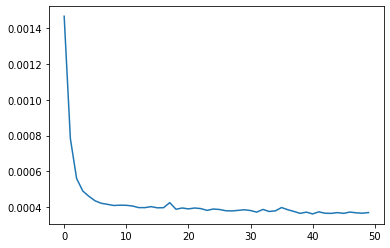

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import tensorflow as tf

r = 0.01
sig = 0.2
T = 30/365

M = 2000
N = 60

dt = T/N
rdt = r*dt
sigsdt = sig * np.sqrt(dt)

np.random.seed(1)
S0 = 1

S = np.empty([M,N+1])
rv = np.random.normal(r*dt,sigsdt,[M,N])

for i in range(M):
    S[i,0] = S0
    for j in range(N):
        S[i,j+1] = S[i,j] * (1+rv[i,j])

#Musiela, M., Rutkowski, M. (1997). Martingale Methods in Financial Modelling. Springer. 214-218.
def afplb_f_call(S0, min, T, r, sig):
    S_min = np.mean(min)
    r11 = (np.log(S0 / S_min) + (r + 0.5 * sig ** 2) * T)/(sig * np.sqrt(T))
    r21 = (np.log(S0 / S_min) + (r - 0.5 * sig ** 2) * T)/(sig * np.sqrt(T))
    r22 = (np.log(S0 / S_min) - (r - 0.5 * sig ** 2) * T)/(sig * np.sqrt(T))

    fst_term = S0 * norm.cdf(r11)
    snd_term = S_min * np.exp(- r * T) * norm.cdf(r21)
    trd_term = S0 * (sig ** 2) * norm.cdf(-r11) / (2 * r)
    fth_term = np.exp(- r * T) * S0 * (sig ** 2) * ((S_min / S0) ** (2 * r / (sig ** 2))) * norm.cdf(-r22) / (2 * r)

    return fst_term - snd_term - trd_term + fth_term

def afplb_f_put(S0, max, T, r, sig):
    S_max = np.mean(max)
    r11 = (np.log(S0 / S_max) + (r + 0.5 * sig ** 2) * T)/(sig * np.sqrt(T))
    r21 = (np.log(S0 / S_max) + (r - 0.5 * sig ** 2) * T)/(sig * np.sqrt(T))
    r22 = (np.log(S0 / S_max) - (r - 0.5 * sig ** 2) * T)/(sig * np.sqrt(T))

    fst_term = S0 * norm.cdf(-r11)
    snd_term = S_max * np.exp(- r * T) * norm.cdf(-r21)
    trd_term = S0 * (sig ** 2) * norm.cdf(r11) / (2 * r)
    fth_term = np.exp(- r * T) * S0 * (sig ** 2) * ((S_max / S0) ** (2 * r / (sig ** 2))) * norm.cdf(r22) / (2 * r)

    return - fst_term + snd_term + trd_term - fth_term

def delta_model(model_name = None):
    price = tf.keras.layers.Input(shape = (1,))
    
    delta = tf.keras.layers.Dense(32, activation='tanh')(price_set)
    delta = tf.keras.layers.Dense(32, activation='tanh')(price)
    delta = tf.keras.layers.BatchNormalization()(delta)
    delta = tf.keras.layers.Dense(32, activation='tanh')(delta)
    delta = tf.keras.layers.BatchNormalization()(delta)
    delta = tf.keras.layers.Dense(32, activation='tanh')(delta)
    delta = tf.keras.layers.Dense(1, activation='tanh')(delta)

    return tf.keras.Model(inputs=price, outputs=delta, name=model_name)

my_input = []

max_price = tf.keras.layers.Input(shape = (1, ), name = 'max_price')
premium = tf.keras.layers.Input(shape = (1, ), name = "premium")
hedge_cost = tf.keras.layers.Input(shape = (1, ), name = 'hedge_cost')
price = tf.keras.layers.Input(shape = (1, ), name = "price")
price_set = tf.keras.layers.Input(shape = (1, ), name = "price_set")

my_input += [max_price] + [premium] + [hedge_cost] + [price]

for j in range(N):
    delta = delta_model()(price)
    new_price = tf.keras.layers.Input(shape = (1, ), name = 'S_' + str(j + 1))
    my_input = my_input + [new_price]

    price_inc = tf.keras.layers.Subtract(name = 'price_inc_' + str(j))([price, new_price])
    cost = tf.keras.layers.Multiply(name = "stock_" + str(j))([delta, price_inc])
    hedge_cost = tf.keras.layers.Add(name = 'cost_' + str(j))([hedge_cost, cost])
    info_set = tf.keras.layers.Concatenate()([price, new_price])
    price = new_price

payoff = tf.keras.layers.Subtract(name = "payoff")([max_price, price])
payoff = tf.keras.layers.Lambda(lambda x : tf.math.maximum(x, 0))(payoff)
cum_cost = tf.keras.layers.Add(name = "hedge_cost_plus_payoff")([hedge_cost, payoff])
cum_cost = tf.keras.layers.Subtract(name = "cum_cost_minus_premium")([cum_cost, premium])

model = tf.keras.Model(inputs = my_input, outputs = cum_cost)

def max_matrix(S):
    maxvec_S = np.zeros([M, 1])
    for j in range(M):
        maxvec_S[j][0] = np.max(S[j][:])
    return maxvec_S

max = max_matrix(S)
max_price = max
premium = afplb_f_put(S0, max, T, r, sig) * np.ones([M, 1])
cost = np.zeros([M, 1])
SS = [S[:, i].reshape(M, 1) for i in range(N + 1)]
x = [max_price] + [premium] + [cost] + [SS]
y = np.zeros([M,1])

model.compile(loss='mse', optimizer='adam')

hist = model.fit(x,y, batch_size=32, epochs=50, verbose=True, validation_split=0.2)

plt.plot(hist.history['loss'])
plt.show()

63/63 [==============================] - 5s 22ms/step


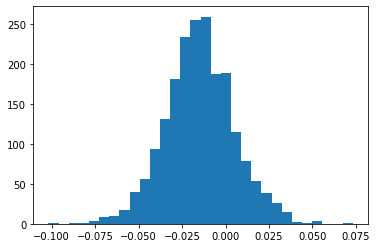

In [ ]:
plt.hist(model.predict(x), bins = 30)
plt.show()

63/63 [==============================] - 1s 20ms/step


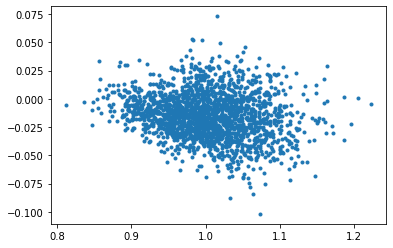

In [ ]:
plt.plot(S[:, -1], model.predict(x), marker = ".", linestyle = 'none')
plt.show()

In [ ]:
def min_matrix(S):
    minvec_S = np.zeros([M, 1])
    for j in range(M):
        minvec_S[j][0] = np.min(S[j][0 : N+1])
    return minvec_S
def max_matrix(S):
    maxvec_S = np.zeros([M, 1])
    for j in range(M):
        maxvec_S[j][0] = np.max(S[j][0 : N+1])
    return maxvec_S

lb_fix_call = np.maximum(np.mean(S[:][N+1] - min_matrix(S)), 0) * np.exp(-r*T)
lb_fix_put = np.maximum(np.mean(max_matrix(S) - S[:][N+1]), 0) * np.exp(-r*T)
print(lb_fix_call, lb_fix_put)

0.08245262740969769 0.0012456355978604655


In [ ]:
print(afplb_f_put(S0, max, T, r, sig))

0.05885521568467633
